In [41]:
%matplotlib inline

In [42]:
%run setup_environment.py
%run custom_tools.py
#%run ml_tools.py

current_conda_env = !echo $CONDA_DEFAULT_ENV
check_conda_env(current_conda_env[0])

Setup environment... done!


✅ <span style='color:green'>Working on **impact-annotator_env** conda environment.</span>

# somatic vs non-somatic classification

In [43]:
impact = pd.read_csv('../../data/annotated_final_IMPACT_mutations_180508.txt', sep = '\t', low_memory = False)

impact.shape

(194211, 63)

## Feature processsing

### `is_somatic`

In [44]:
get_table(impact.confidence_class)

,count_,freq_
AUTO_OK,180832,93.1%
UNLIKELY,7199,3.7%
MANUAL_OK,6180,3.2%


In [45]:
impact['is_somatic'] = impact.confidence_class != "UNLIKELY"
get_table(impact.is_somatic)

,count_,freq_
True,187012,96.3%
False,7199,3.7%


## Setup the train/test sets

In [46]:
label_feature_name = 'is_somatic'

In [47]:
# shuffle data
rng = np.random.RandomState(0)
permutation = rng.permutation(len(impact))
impact_selected = impact.iloc[permutation]

impact_selected = impact_selected.iloc[0:20000]

### Choose features

In [48]:
feature_names = [
# 'Hugo_Symbol', 'Chromosome', 'Start_Position', 'End_Position', 'Consequence', 'Variant_Type', 'Reference_Allele', 'Tumor_Seq_Allele2', 'Tumor_Sample_Barcode',
# 'cDNA_change', 'HGVSp_Short',
't_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count',
# 't_ref_plus_count', 't_ref_neg_count', 't_alt_plus_count', 't_alt_neg_count',
#'confidence_class',
'sample_coverage',
#'mut_key',
#'VAG_VT', 'VAG_GENE', 'VAG_cDNA_CHANGE', 'VAG_PROTEIN_CHANGE', 'VAG_EFFECT',
'VEP_Consequence',
#'VEP_SYMBOL', 'VEP_HGVSc', 'VEP_HGVSp',
#'VEP_Amino_acids',
'VEP_VARIANT_CLASS',
#'VEP_EXON', 'VEP_INTRON',
'VEP_IMPACT',
'VEP_CLIN_SIG',
'VEP_COSMIC_CNT',
'VEP_gnomAD_AF',
#'sample_mut_key', 'patient_key',
'frequency_in_normals',
#'VEP_SIFT_class',
#'VEP_SIFT_score',
#'VEP_PolyPhen_class',
#'VEP_PolyPhen_score',
'VEP_in_dbSNP',
'VEP_gnomAD_total_AF_AFR',
'VEP_gnomAD_total_AF_AMR',
'VEP_gnomAD_total_AF_ASJ',
'VEP_gnomAD_total_AF_EAS',
'VEP_gnomAD_total_AF_FIN',
'VEP_gnomAD_total_AF_NFE',
'VEP_gnomAD_total_AF_OTH',
'VEP_gnomAD_total_AF_max',
'VEP_gnomAD_total_AF',
'Kaviar_AF',
#'is_a_hotspot',
#'is_a_3d_hotspot',
#'oncogenic',
'gene_type',
label_feature_name
]

categorical_features_names = [
'VEP_Consequence',
#'VEP_Amino_acids',
'VEP_VARIANT_CLASS',
'VEP_IMPACT',
'VEP_CLIN_SIG',
#'VEP_SIFT_class',
#'VEP_PolyPhen_class',
'VEP_in_dbSNP',
'gene_type',
]

In [49]:
impact_selected = impact_selected[feature_names].dropna()
impact_selected.shape

(20000, 27)

In [50]:
impact_selected = pd.get_dummies(impact_selected, columns = categorical_features_names, sparse = True)
impact_selected.shape

(20000, 46)

### Split features from label

In [51]:
X = impact_selected.drop(label_feature_name, axis = 1) # features matrix X: [n_samples, n_features]
y = impact_selected[label_feature_name]                # target array y: n_samples
print(X.shape)
print(y.shape)

(20000, 45)
(20000,)


In [52]:
get_table(y)

,count_,freq_
True,19260,96.3%
False,740,3.7%


In [53]:
n_folds = 5

## Main functions

In [54]:
from sklearn.model_selection import StratifiedShuffleSplit

# returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)

In [55]:
i = 0
for train_index, test_index in cv_strategy.split(X, y):
    print("Fold %d :\n" % i,
          "  → train_index (%5d elements) %s\n" % (len(train_index), str(train_index)),
          "  → test_index  (%5d elements) %s" % (len(test_index), str(test_index)))
    i += 1

Fold 0 :
   → train_index (16000 elements) [ 2494 13977 19714 ... 12567  7139  8109]
   → test_index  ( 4000 elements) [17200  9818  8066 ...  1519  8493  7331]
Fold 1 :
   → train_index (16000 elements) [10848 10921  5705 ...  2531 17296  4705]
   → test_index  ( 4000 elements) [18574  1756  3090 ... 15960 19793 17802]
Fold 2 :
   → train_index (16000 elements) [17030  4239 15184 ... 14031   358  7930]
   → test_index  ( 4000 elements) [ 8677  6485  5379 ... 11999 17653  7937]
Fold 3 :
   → train_index (16000 elements) [7541 8338 4085 ... 9970   18 2157]
   → test_index  ( 4000 elements) [ 1903 10520  5100 ... 16895 12922 10126]
Fold 4 :
   → train_index (16000 elements) [ 4443 14676  3734 ...  3962 15274 10402]
   → test_index  ( 4000 elements) [14205  4733 11048 ... 11557  4940 18528]


In [76]:
from sklearn.model_selection import cross_validate

def print_train_test_metrics(metrics, fold_number):
    print("Fold #: [fit_time | score_time]\n",
          "  → accuracy: [test_accuracy | train_accuracy]\n",
          "  → ROC AUC : [test_roc_auc  | train_roc_auc]\n")
    
    for i in range(fold_number):
        print("Fold %d: [%.2fs | %.2fs]\n"    % (i, metrics['fit_time'][i], metrics['score_time'][i]) +
              "  → accuracy: [%.3f | %.3f]\n" % (metrics['test_accuracy'][i], metrics['train_accuracy'][i]) +
              "  → ROC AUC : [%.3f | %.3f]"   % (metrics['test_roc_auc'][i]  , metrics['train_roc_auc'][i]))
        
    print()

def run(model, X, y, cv_strategy, print_fold_metrics = False, plot_roc = False, ax = None):
    scoring_metrics = ['accuracy', 'roc_auc']
    
    metrics = cross_validate(model, X, y, cv = cv_strategy, scoring = scoring_metrics, return_train_score = True) # n_jobs, pre_dispatch
    
    if print_fold_metrics:
        print_train_test_metrics(metrics, cv_strategy.get_n_splits())
    
    # mean metrics and 95% confidence interval on the metrics estimate (= 1.96 x standard_deviation)
    print("## Accuracy: %0.2f ± %0.2f\n" % (np.mean(metrics['test_accuracy']),
                                                1.96 * np.std(metrics['test_accuracy'])) +
          "## ROC AUC : %0.2f ± %0.2f" % (np.mean(metrics['test_roc_auc']),
                                              1.96 * np.std(metrics['test_roc_auc'])))
    
    if plot_roc:
        run_roc(model, X, y, cv_strategy, ax)

# strongly inspired by http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
def run_roc(model, X, y, cv_strategy, ax):
    from scipy import interp
    from sklearn.metrics import roc_curve, auc
    
    mean_fpr = np.linspace(0, 1, 100) # [0, 0.01, 0.02, ..., 0.09]
    tprs = [] # True Positive Rate for each fold
    aucs = [] # ROC AUC for each fold
            
    i = 0
    for train_index, test_index in cv_strategy.split(X, y):
        model.fit(X.iloc[train_index], y.iloc[train_index])
        y_pred = model.predict_proba(X.iloc[test_index])
        # y_pred: 1st column = proba of 0 (y_pred[:, 0]), 2nd column = proba of 1 (y_pred[:, 1])
        
        # fpr: false positive rate
        # tpr: true positive rate
        fpr, tpr, thresholds = roc_curve(y.iloc[test_index], y_pred[:, 1])
                
        # because the length of fpr and tpr vary with the fold (size of thersholds  = nunique(y_pred[:, 1]) + 1), we can't just do
        # fprs.append(fpr) and tprs.append(tpr)
        tprs.append(interp(mean_fpr, fpr, tpr)) # linear interpolation to find the values for a 100 tpr
        tprs[-1][0] = 0.0 # threshold > 1 for the first point
        
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        ax.plot(fpr, tpr, linewidth = 0.7, alpha = 0.5,
                label = 'ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        
    ax.plot([0, 1], [0, 1], '--r', linewidth = 0.5, alpha = 0.8, label = 'random')
    
    ##############
    ## mean ROC ##
    ##############
    mean_tpr = np.mean(tprs, axis = 0)
    ax.plot(mean_fpr, mean_tpr, 'b', linewidth = 1,
            label = 'mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (np.mean(aucs), 1.96 * np.std(aucs)))

    ##################
    ## mean ROC std ##
    ##################
    std_tprs = np.std(tprs, axis = 0)
    ax.fill_between(mean_fpr, mean_tpr - std_tprs, mean_tpr + std_tprs, color = 'blue', alpha = 0.2,
                     label='$\pm$ 1 std. dev.')

    
    #####################
    ## plot parameters ##
    #####################
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc = "lower right", prop = {'size': 10})

## Dummy

### Uniform

## Accuracy: 0.49 ± 0.00
## ROC AUC : 0.50 ± 0.00


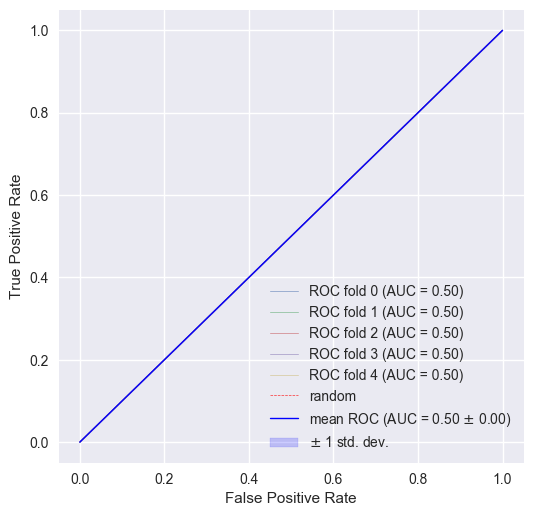

In [78]:
from sklearn.dummy import DummyClassifier

model_uniform = DummyClassifier(strategy = 'uniform', random_state = 1)
# generates predictions uniformly at random
#   → expected accuracy: 0.5 | expected AUC: 0.5

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run(model_uniform, X, y, cv_strategy, plot_roc = True, ax = ax)

### Most Frequent

## Accuracy: 0.96 ± 0.00
## ROC AUC : 0.50 ± 0.00


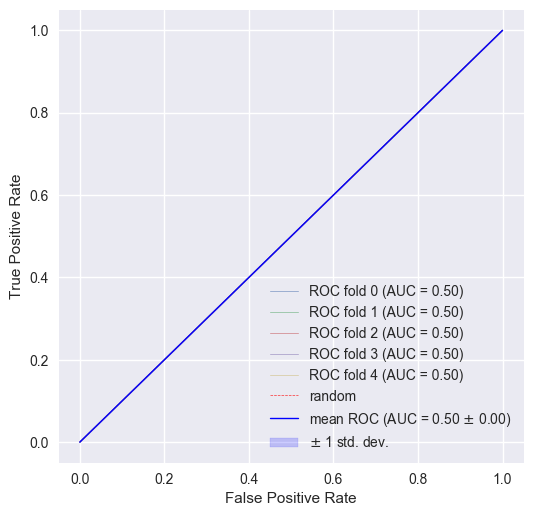

In [79]:
from sklearn.dummy import DummyClassifier

model_most_frequent = DummyClassifier(strategy = 'most_frequent', random_state = 1)
# always predicts the most frequent label in the training set
#   → expected accuracy: proportion of the most reccurent class in the dataset | expected AUC: 0.5

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run(model_most_frequent, X, y, cv_strategy, plot_roc = True, ax = ax)

## Gaussian Naive Bayes

## Accuracy: 0.93 ± 0.01
## ROC AUC : 0.79 ± 0.03


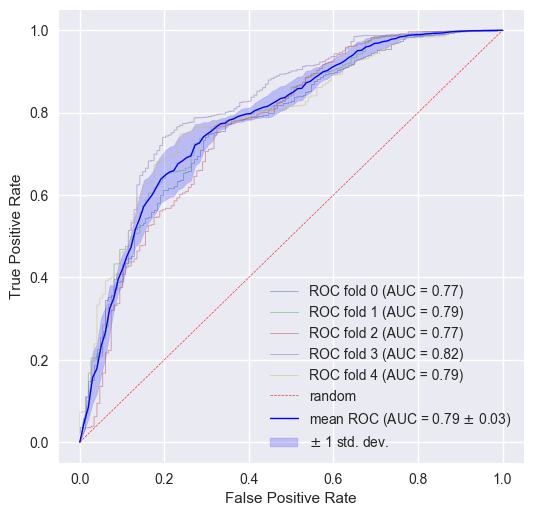

In [80]:
from sklearn.naive_bayes import GaussianNB

model_GaussianNB = GaussianNB()

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run(model_GaussianNB, X, y, cv_strategy, plot_roc = True, ax = ax)

In [86]:
#from sklearn.naive_bayes import ComplementNB

#model_ComplementNB = ComplementNB()

#fig, ax = plt.subplots(1, 1, figsize = (6, 6))
#run(model_ComplementNB, X, y, cv_strategy, plot_roc = True, ax = ax)

## Logistic Regression

## Accuracy: 0.97 ± 0.00
## ROC AUC : 0.82 ± 0.04


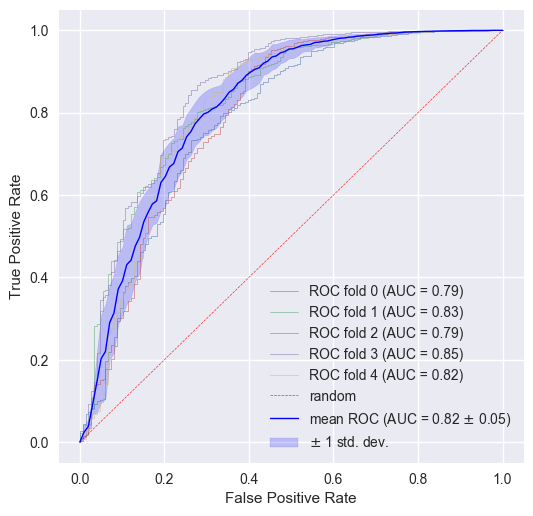

In [87]:
from sklearn.linear_model import LogisticRegressionCV

model_LogisticRegressionCV = LogisticRegressionCV(random_state = 1)
# Logistic Regression with builtin cross-validation to find out the optimal C parameter

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run(model_LogisticRegressionCV, X, y, cv_strategy, plot_roc = True, ax = ax)

## K Nearest Neighbors

In [96]:
from sklearn.model_selection import GridSearchCV

#parameters_grid = [
#    {'n_neighbors': [1, 2, 3, 5, 10, 20, 50], 'weights': ['uniform', 'distance']}
#]

parameters_grid = [
    {'n_neighbors': [1, 2], 'weights': ['uniform']}
]

test = GridSearchCV(KNeighborsClassifier(), parameters_grid, cv = cv_strategy, scoring = 'accuracy', return_train_score = True)

In [97]:
a = test.fit(X, y)
print(a.best_params_)
print(a.cv_results_)

{'n_neighbors': 1, 'weights': 'uniform'}
{'mean_fit_time': array([0.35031362, 0.38465972]), 'std_fit_time': array([0.09229724, 0.03677871]), 'mean_score_time': array([0.3408288, 0.5536684]), 'std_score_time': array([0.01506415, 0.09081729]), 'param_n_neighbors': masked_array(data=[1, 2],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_weights': masked_array(data=['uniform', 'uniform'],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 1, 'weights': 'uniform'}, {'n_neighbors': 2, 'weights': 'uniform'}], 'split0_test_score': array([0.93975, 0.91625]), 'split1_test_score': array([0.9375 , 0.91575]), 'split2_test_score': array([0.9445 , 0.91975]), 'split3_test_score': array([0.94375, 0.9175 ]), 'split4_test_score': array([0.94275, 0.92225]), 'mean_test_score': array([0.94165, 0.9183 ]), 'std_test_score': array([0.00262964, 0.00241039]), 'rank_test_score': array([1, 2], dtype=int32), 'spl

array([0.91625, 0.91575, 0.91975, 0.9175 , 0.92225])

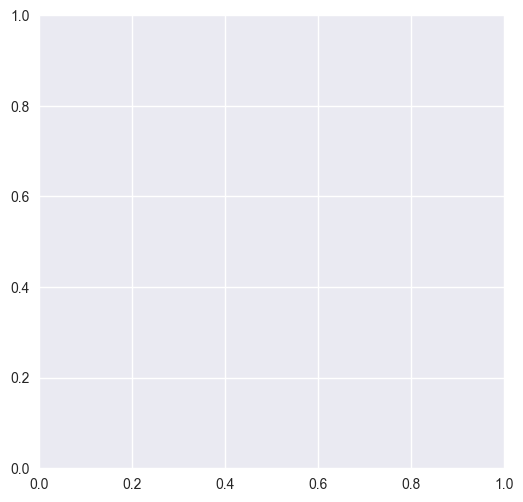

In [135]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

parameters_grid = [
    {'n_neighbors': [1, 2]}
]

# 'weights': ['uniform']

# inner cross validation on hyperparameters
inner_cv_strategy = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 1)

model_GS_KNeighborsClassifier = GridSearchCV(KNeighborsClassifier(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', return_train_score = True, refit = True, n_jobs = -1)
#model_GS_KNeighborsClassifier.fit(X, y)
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
#run(model_GS_KNeighborsClassifier, X, y, cv_strategy, print_fold_metrics = True, plot_roc = True, ax = ax)
cross_val_score(model_GS_KNeighborsClassifier, X, y, cv = cv_strategy, scoring = 'roc_auc')

## Accuracy: 0.97 ± 0.00
## ROC AUC : 0.82 ± 0.05
## Accuracy: 0.97 ± 0.00
## ROC AUC : 0.82 ± 0.05


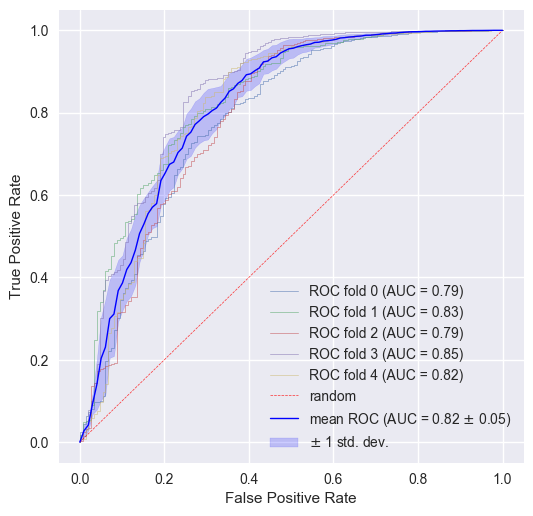

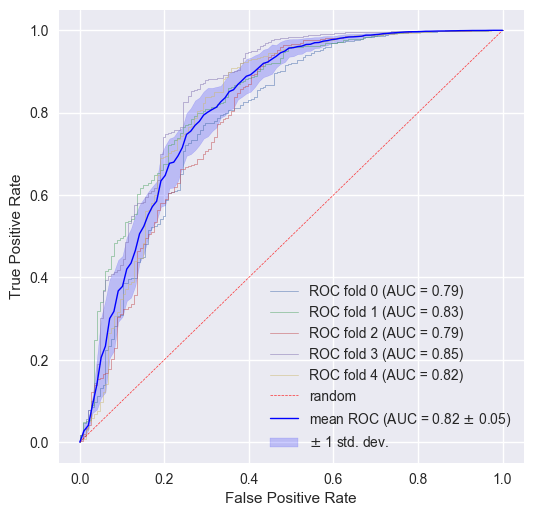

In [127]:
model_KNeighborsClassifier = KNeighborsClassifier(n_neighbors = 1)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run(model_LogisticRegressionCV, X, y, cv_strategy, plot_roc = True, ax = ax)


model_KNeighborsClassifier = KNeighborsClassifier(n_neighbors = 2)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run(model_LogisticRegressionCV, X, y, cv_strategy, plot_roc = True, ax = ax)

In [122]:
from sklearn.model_selection import GridSearchCV

def print_parameters_search_recap(grid_search_model):
    print("Best parameters (see accuracy scores below): %s" % str(grid_search_model.best_params_))
    
    for mean, std, parameters in zip(grid_search_model.cv_results_['mean_test_score'],
                                     grid_search_model.cv_results_['std_test_score'],
                                     grid_search_model.cv_results_['params']):
        print("%0.2f ± %0.2f for %r" % (mean, 1.96 * std, parameters))


def run_grid_search(model, X, y, inner_cv_strategy, parameters_grid):
    grid_search_model = GridSearchCV(model, parameters_grid, cv = inner_cv_strategy, scoring = 'accuracy', return_train_score = True, refit = True)
    grid_search_model.fit(X, y)
    
    print_parameters_search_recap(grid_search_model)
    
    return (GridSearchCV(model, parameters_grid, cv = inner_cv_strategy, scoring = 'accuracy', return_train_score = True, refit = True))

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes = np.linspace(0.1, 1.0, 5), cv = 5)

for i in range(n_folds):
    plt.plot(train_sizes, train_scores[i], linewidth = 0.5, alpha = 0.4, color = 'r',
                     label = 'training score fold %d' % i)
    plt.plot(train_sizes, test_scores[i], linewidth = 0.5, alpha = 0.4, color = 'g',
                     label = 'test score fold %d' % i)
    
train_scores_mean = np.mean(train_scores, axis = 0)
train_scores_std = np.std(train_scores, axis = 0)
test_scores_mean = np.mean(test_scores, axis = 0)
test_scores_std = np.std(test_scores, axis = 0)

plt.plot(train_sizes, train_scores_mean, 'o-r', linewidth = 1,
        label = 'mean training score')
plt.plot(train_sizes, test_scores_mean, 'o-g', linewidth = 1,
         label = 'mean test score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')


plt.xlabel("Training size")
plt.ylabel("Accuracy score")
plt.legend(loc = "lower right", prop = {'size': 5})

## K Nearest Neighbors

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_neighbors': [1, 2, 3, 5, 10, 20, 50], 'weights': ['uniform', 'distance']}
]

GridSearchCV(scoring = 'roc_auc')

**K Nearest Neighbors** Accuracy: 0.89 ± 0.00 | AUC: 0.81 ± 0.01

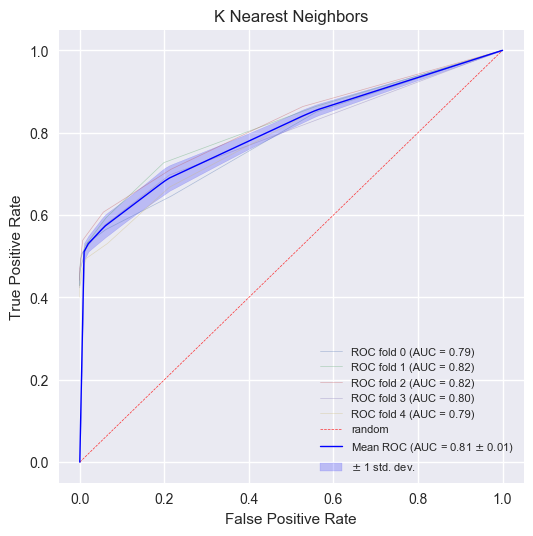

In [70]:
from sklearn.neighbors import KNeighborsClassifier


model_KNeighborsClassifier = KNeighborsClassifier(n_neighbors = 10)

get_accuracy_and_AUC(model_KNeighborsClassifier, X, y, n_folds, 'K Nearest Neighbors')

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_cross_validation_ROC_curves(model_KNeighborsClassifier, X, y, n_folds, 'K Nearest Neighbors', ax);

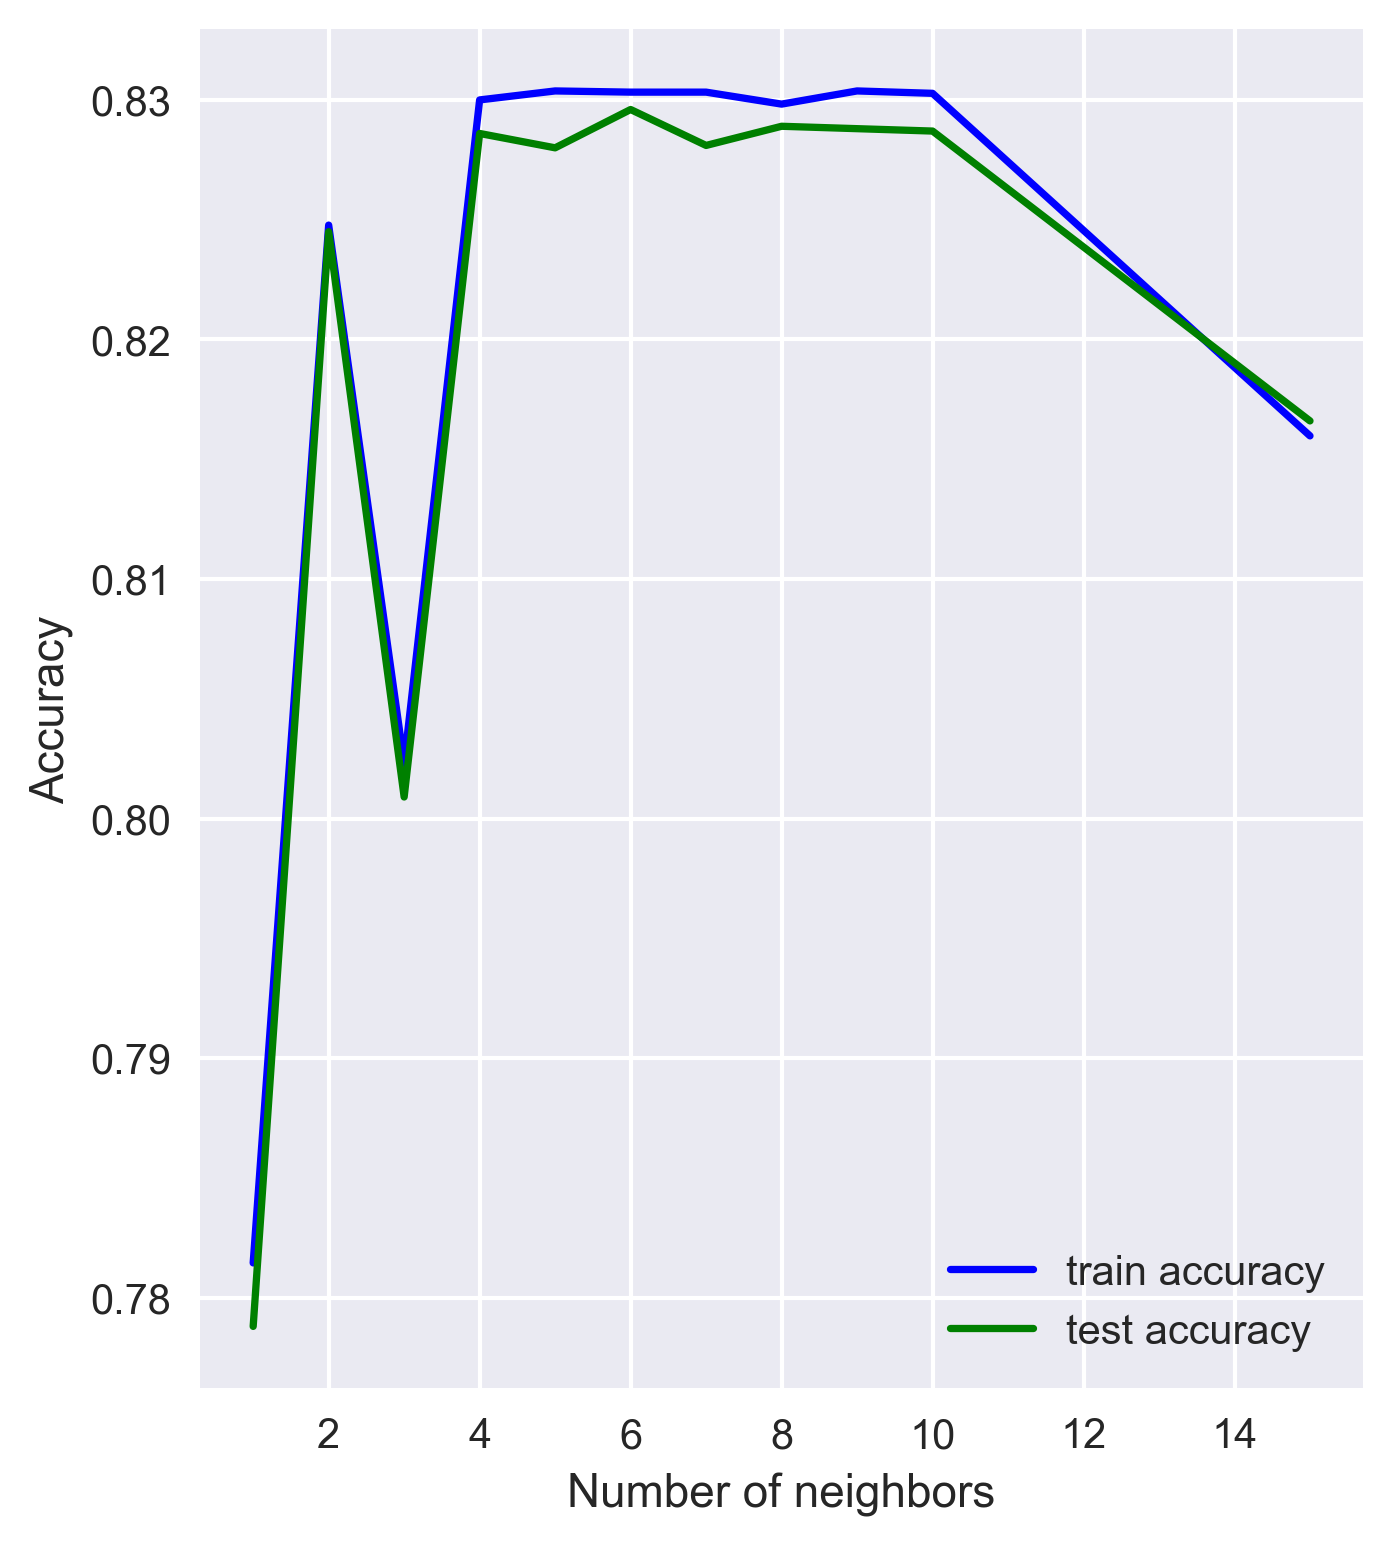

In [110]:
from sklearn.model_selection import validation_curve
n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
train_scores, test_scores = validation_curve(KNeighborsClassifier(), X, y, param_name = "n_neighbors", param_range = n_neighbors, cv = n_folds)

plt.figure(figsize = (5, 6))
plt.plot(n_neighbors, train_scores.mean(axis = 1), 'b', label = "train accuracy")
plt.plot(n_neighbors, test_scores.mean(axis = 1), 'g', label = "test accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Number of neighbors')
#plt.xlim([50, 0])
plt.legend(loc = "best");

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_RandomForestClassifier = RandomForestClassifier(n_estimators = 200)

get_accuracy_and_AUC(model_RandomForestClassifier, X, y, n_folds, 'Random Forest')

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_cross_validation_ROC_curves(model_RandomForestClassifier, X, y, n_folds, 'Random Forest', ax);

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC

model = SVC(kernel = 'linear', C = 1E10)

accuracy_scores = cross_val_score(model, X, y, cv = 5)
auc_scores = cross_val_score(model, X, y, cv = n_folds, scoring = "roc_auc")
print("Accuracy: %0.2f ± %0.2f | AUC: %0.2f ± %0.2f" % (accuracy_scores.mean(), accuracy_scores.std(), auc_scores.mean(), auc_scores.std()))
plot1 = plot_cross_validation_ROC_curves(model, X, y, n_folds);

Gradient boosting